# Introduction

In this project, I will be forecasting the weekly average price of avocados in Los Angeles for the next year. The dataset can be found on kaggle (https://www.kaggle.com/datasets/vakhariapujan/avocado-prices-and-sales-volume-2015-2023) and is data collected from the Hass Avocado Board. It contains the weekly average price of avocados in certain regions in the United States. I have specifically selected the 'Los Angeles' region for my analysis.

Because this is a timeseries forecasting problem, I will be employing the Multivariate Timeseries LSTM Model.

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, LeakyReLU, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam


from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
df = pd.read_csv('/Users/anthonycheung/Downloads/Avocado_HassAvocadoBoard_20152023v1.0.1.csv')

In [3]:
df

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
0,2015-01-04,1.220000,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,Albany
1,2015-01-04,1.790000,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,Albany
2,2015-01-04,1.000000,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,Atlanta
3,2015-01-04,1.760000,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,Atlanta
4,2015-01-04,1.080000,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,BaltimoreWashington
...,...,...,...,...,...,...,...,...,...,...,...,...
53410,2023-12-03,1.550513,5693.91,204.64,1211.25,0.00,4278.03,NaN,NaN,NaN,organic,Toledo
53411,2023-12-03,1.703920,343326.10,66808.44,132075.11,58.65,138830.45,NaN,NaN,NaN,organic,West
53412,2023-12-03,1.618931,34834.86,15182.42,1211.38,0.00,18075.66,NaN,NaN,NaN,organic,WestTexNewMexico
53413,2023-12-03,1.245406,2942.83,1058.54,7.46,0.00,1779.19,NaN,NaN,NaN,organic,Wichita


In [4]:
df.shape

(53415, 12)

The columns plu4046, plu4425, and plu4770 indicate the size (in weight) of the avocados sold whereas the bags indicate pre-packaged containers consisting of different PLU mixes.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53415 entries, 0 to 53414
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          53415 non-null  object 
 1   AveragePrice  53415 non-null  float64
 2   TotalVolume   53415 non-null  float64
 3   plu4046       53415 non-null  float64
 4   plu4225       53415 non-null  float64
 5   plu4770       53415 non-null  float64
 6   TotalBags     53415 non-null  float64
 7   SmallBags     41025 non-null  float64
 8   LargeBags     41025 non-null  float64
 9   XLargeBags    41025 non-null  float64
 10  type          53415 non-null  object 
 11  region        53415 non-null  object 
dtypes: float64(9), object(3)
memory usage: 4.9+ MB


In [6]:
df['region'].value_counts()

California              932
West                    932
BuffaloRochester        932
Indianapolis            932
Syracuse                932
Plains                  932
BaltimoreWashington     932
Northeast               932
Denver                  932
Orlando                 932
Sacramento              932
Columbus                932
Jacksonville            932
Atlanta                 932
Boston                  932
SouthCentral            932
LasVegas                932
Philadelphia            932
Pittsburgh              932
Albany                  932
SouthCarolina           932
TotalUS                 932
Roanoke                 932
Tampa                   932
RichmondNorfolk         932
HartfordSpringfield     932
LosAngeles              932
Portland                932
Spokane                 932
Midsouth                932
NewYork                 932
SanFrancisco            932
GrandRapids             932
Louisville              932
RaleighGreensboro       932
NewOrleans          

In [7]:
# Filtering dataset for Los Angeles region only
la = df[df['region'] == 'LosAngeles']

In [8]:
la.head(10)

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
44,2015-01-04,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,LosAngeles
45,2015-01-04,1.25,54495.54,47721.51,1723.40,0.00,5050.63,5050.63,0.00,0.00,organic,LosAngeles
152,2015-01-11,0.85,2713699.60,1786326.65,617233.39,58892.91,251246.65,222971.68,25111.74,3163.23,conventional,LosAngeles
153,2015-01-11,1.08,60232.63,52087.31,2063.44,0.00,6081.88,6081.88,0.00,0.00,organic,LosAngeles
260,2015-01-18,0.89,2800679.50,1925013.31,526106.80,59364.23,290195.16,260857.96,26671.18,2666.02,conventional,LosAngeles
261,2015-01-18,1.29,43649.12,33738.87,1368.91,0.00,8541.34,8541.34,0.00,0.00,organic,LosAngeles
368,2015-01-25,0.96,2329987.29,1518406.36,456562.55,60922.43,294095.95,255279.65,36398.19,2418.11,conventional,LosAngeles
369,2015-01-25,1.23,38078.07,28037.64,1355.80,0.00,8684.63,8684.63,0.00,0.00,organic,LosAngeles
476,2015-02-01,0.74,4031949.04,2770656.27,854673.24,64439.70,342179.83,308754.64,31108.07,2317.12,conventional,LosAngeles
477,2015-02-01,1.12,50107.32,39628.65,1721.95,0.00,8756.72,8756.72,0.00,0.00,organic,LosAngeles


In [9]:
la = la[la['type'] == 'conventional']

In [10]:
duplicates = la.duplicated()
duplicate_count = duplicates.sum()
print(f'Total duplicate rows: {duplicate_count}')

Total duplicate rows: 0


In [11]:
la.head(10)

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
44,2015-01-04,0.85,2682159.95,1837999.65,524430.47,64225.78,255504.05,215571.80,36981.72,2950.53,conventional,LosAngeles
152,2015-01-11,0.85,2713699.60,1786326.65,617233.39,58892.91,251246.65,222971.68,25111.74,3163.23,conventional,LosAngeles
260,2015-01-18,0.89,2800679.50,1925013.31,526106.80,59364.23,290195.16,260857.96,26671.18,2666.02,conventional,LosAngeles
368,2015-01-25,0.96,2329987.29,1518406.36,456562.55,60922.43,294095.95,255279.65,36398.19,2418.11,conventional,LosAngeles
476,2015-02-01,0.74,4031949.04,2770656.27,854673.24,64439.70,342179.83,308754.64,31108.07,2317.12,conventional,LosAngeles
584,2015-02-08,0.90,2641032.65,1673425.82,582236.24,58216.26,327154.33,280560.62,44327.49,2266.22,conventional,LosAngeles
692,2015-02-15,0.83,2926435.94,2146773.46,408395.74,62511.83,308754.91,271596.41,35034.18,2124.32,conventional,LosAngeles
800,2015-02-22,0.83,2954705.54,2050402.87,505580.16,61573.28,337149.23,309850.06,25218.02,2081.15,conventional,LosAngeles
908,2015-03-01,0.75,3094278.93,2145439.03,592196.29,61863.94,294779.67,269524.60,23570.43,1684.64,conventional,LosAngeles
1016,2015-03-08,0.86,2797745.89,2005781.71,400644.42,62567.60,328752.16,311497.60,15650.13,1604.43,conventional,LosAngeles


In [12]:
# Separate dates for future graph plotting
train_dates = pd.to_datetime(la['Date'])

In [13]:
# Column variable names for ML training
cols = list(la)[0:10]

In [14]:
print(cols)

['Date', 'AveragePrice', 'TotalVolume', 'plu4046', 'plu4225', 'plu4770', 'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags']


In [15]:
df_for_training = la[cols]
df_for_training = df_for_training.copy()

In [16]:
df_for_training.loc[:, 'Date'] = pd.to_datetime(df_for_training['Date'])
df_for_training.loc[:, 'AveragePrice'] = pd.to_numeric(df_for_training['AveragePrice'], errors='coerce')

In [17]:
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 44 to 53320
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          466 non-null    datetime64[ns]
 1   AveragePrice  466 non-null    float64       
 2   TotalVolume   466 non-null    float64       
 3   plu4046       466 non-null    float64       
 4   plu4225       466 non-null    float64       
 5   plu4770       466 non-null    float64       
 6   TotalBags     466 non-null    float64       
 7   SmallBags     361 non-null    float64       
 8   LargeBags     361 non-null    float64       
 9   XLargeBags    361 non-null    float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 40.0 KB


In [18]:
# Feature engineering
df_for_training['rolling_avg_5'] = df_for_training['AveragePrice'].rolling(window=5).mean()
df_for_training['Date'] = pd.to_datetime(df_for_training['Date'])
df_for_training['day_of_week'] = df_for_training['Date'].dt.dayofweek  
df_for_training['month'] = df_for_training['Date'].dt.month 

In [19]:
# Including lag features
df_for_training['lag_1'] = df['AveragePrice'].shift(1)
df_for_training['lag_2'] = df['AveragePrice'].shift(2)
df_for_training['lag_3'] = df['AveragePrice'].shift(3)

In [20]:
df_for_training.drop(columns=['Date'], inplace=True)
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 44 to 53320
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AveragePrice   466 non-null    float64
 1   TotalVolume    466 non-null    float64
 2   plu4046        466 non-null    float64
 3   plu4225        466 non-null    float64
 4   plu4770        466 non-null    float64
 5   TotalBags      466 non-null    float64
 6   SmallBags      361 non-null    float64
 7   LargeBags      361 non-null    float64
 8   XLargeBags     361 non-null    float64
 9   rolling_avg_5  462 non-null    float64
 10  day_of_week    466 non-null    int64  
 11  month          466 non-null    int64  
 12  lag_1          466 non-null    float64
 13  lag_2          466 non-null    float64
 14  lag_3          466 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 58.2 KB


In [21]:
# Fill NaN cells with 0
df_for_training = df_for_training.fillna(0)

In [22]:
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 44 to 53320
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AveragePrice   466 non-null    float64
 1   TotalVolume    466 non-null    float64
 2   plu4046        466 non-null    float64
 3   plu4225        466 non-null    float64
 4   plu4770        466 non-null    float64
 5   TotalBags      466 non-null    float64
 6   SmallBags      466 non-null    float64
 7   LargeBags      466 non-null    float64
 8   XLargeBags     466 non-null    float64
 9   rolling_avg_5  466 non-null    float64
 10  day_of_week    466 non-null    int64  
 11  month          466 non-null    int64  
 12  lag_1          466 non-null    float64
 13  lag_2          466 non-null    float64
 14  lag_3          466 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 58.2 KB


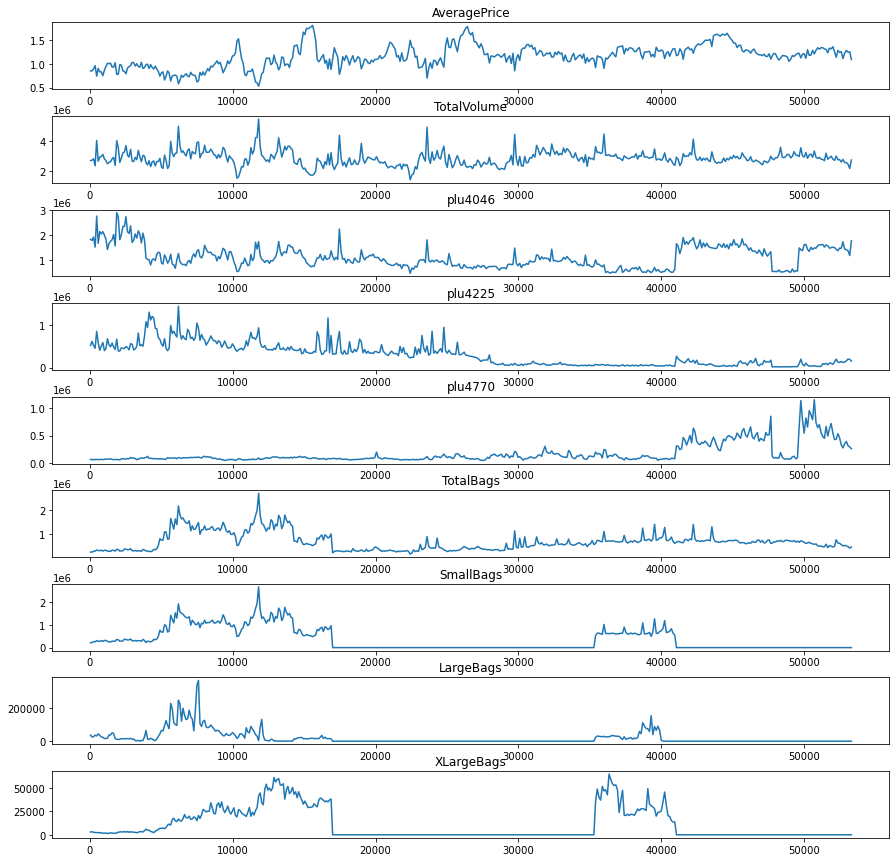

In [23]:
# Plotting the variable columns
figure, axes = plt.subplots(nrows=9, figsize=(15, 15))

for ax, col in zip(axes, df_for_training.columns):
    ax.plot(df_for_training[col])
    ax.set_title(col)
    ax.axes
    
plt.subplots_adjust(hspace=0.4)

plt.show()

In [24]:
# Feature Scaling
scaler = MinMaxScaler(feature_range =(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [25]:
df_for_training.shape

(466, 15)

In [26]:
df_for_training_scaled.shape

(466, 15)

In [27]:
# Reshaping the dataset to allow the LSTM model to run the data
x_data = []
y_data = []

n_future = 1   # number of weeks we want to predict into the future
n_past = 20     # number of past weeks we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    x_data.append(df_for_training_scaled[i - n_past: i, 0: df_for_training.shape[1]])
    y_data.append(df_for_training_scaled[i + n_future - 1, 0]) 

In [28]:
x_data, y_data = np.array(x_data), np.array(y_data)

In [29]:
print('x_data shape == {}.'.format(x_data.shape))
print('y_data shape == {}.'.format(y_data.shape))

x_data shape == (446, 20, 15).
y_data shape == (446,).


In [30]:
# Splitting the data into training and testing

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state = 50, shuffle=False)
print(f'x_train shape: {x_train.shape}, x_test shape: {x_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

x_train shape: (356, 20, 15), x_test shape: (90, 20, 15)
y_train shape: (356,), y_test shape: (90,)


In [31]:
# Define LSTM model
model = Sequential()

model.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))

model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(Bidirectional(LSTM(64, return_sequences=False)))

model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

model.build(input_shape=(None, x_train.shape[1], x_train.shape[2]))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 20, 512)           557056    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 256)           656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1377921 (5.26 MB)
Trainable params: 1377921 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [33]:
# Fitting the model
history = model.fit(x_train, y_train, epochs=150, batch_size=24, validation_split=0.1, callbacks=early_stopping, verbose=1)

Epoch 1/150
14/14 [==============================] - 9s 179ms/step - loss: 0.0656 - val_loss: 0.0041
Epoch 2/150
14/14 [==============================] - 1s 72ms/step - loss: 0.0275 - val_loss: 0.0061
Epoch 3/150
14/14 [==============================] - 1s 72ms/step - loss: 0.0176 - val_loss: 0.0106
Epoch 4/150
14/14 [==============================] - 1s 71ms/step - loss: 0.0150 - val_loss: 0.0099
Epoch 5/150
14/14 [==============================] - 1s 81ms/step - loss: 0.0133 - val_loss: 0.0050
Epoch 6/150
14/14 [==============================] - 1s 72ms/step - loss: 0.0126 - val_loss: 0.0045
Epoch 7/150
14/14 [==============================] - 1s 72ms/step - loss: 0.0119 - val_loss: 0.0040
Epoch 8/150
14/14 [==============================] - 1s 73ms/step - loss: 0.0114 - val_loss: 0.0046
Epoch 9/150
14/14 [==============================] - 1s 74ms/step - loss: 0.0115 - val_loss: 0.0039
Epoch 10/150
14/14 [==============================] - 1s 73ms/step - loss: 0.0105 - val_loss: 0.006

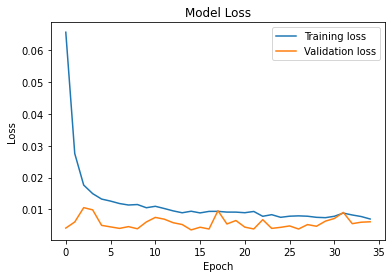

In [34]:
# Plotting the Training and Validation Loss 
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [35]:
# checking the accuracy of the model by making a prediction with the test set
predictions = model.predict(x_test)
num_features = x_test.shape[2]

# check the shape of predictions
print(f"x_test shape: {x_test.shape}")  
print(f"Predictions shape: {predictions.shape}")  

# use only the last time step's prediction for each sample
predictions_last_step = predictions[:, -1]  

# flatten the last step predictions to make it a 1D array
predictions_last_step = predictions_last_step.flatten()  # Now shape will be (90,)

# inverse transform predictions
predictions_reshaped = np.zeros((predictions_last_step.shape[0], num_features))  # create an array with the same number of features
predictions_reshaped[:, 0] = predictions_last_step  # fill the first column with the last step's predictions
predictions_rescaled = scaler.inverse_transform(predictions_reshaped)[:, 0]  # get only the first column after inversion

# check the shape after inverse transformation
print(f"Predictions rescaled shape: {predictions_rescaled.shape}")  

# inverse transform y_test
y_test_reshaped = np.zeros((y_test.shape[0], num_features))  
y_test_reshaped[:, 0] = y_test.flatten()  

# ensure y_test_reshaped is correctly shaped
y_test_rescaled = scaler.inverse_transform(y_test_reshaped)[:, 0]  

# check the shape after inverse transformation
print(f"y_test rescaled shape: {y_test_rescaled.shape}") 

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

3/3 [==============================] - 2s 26ms/step
x_test shape: (90, 20, 15)
Predictions shape: (90, 1)
Predictions rescaled shape: (90,)
y_test rescaled shape: (90,)
Mean Squared Error: 0.006955702364541753
Mean Absolute Error: 0.06280345925190779
R-squared: 0.6991894708609285


__Model's Performance Metrics for Predicting Avocado Prices__

1. __Mean Squared Error:__
    The average of squared differences between predicted and actual values of 0.00696 is very low.
    
2. __Mean Absolute Error:__
    On average, the model's predictions are off by about 6.28 cents. Given that avocado prices fluctuate within a   few dollars, this level accuracy seems quite reasonable and practical for my purpose.
    
3. __R-squared:__
    Approximately 69.9% of the variance in avocado prices is explained by my model. Although it's not the most accurate, the model captures a significant protion of the underlying trends in avocado prices.

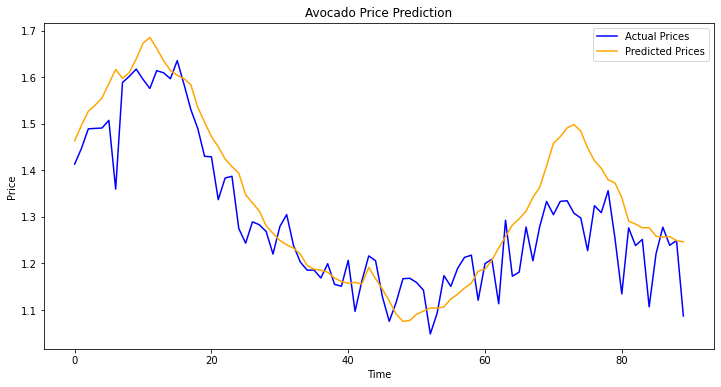

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(predictions_rescaled, label='Predicted Prices', color='orange')
plt.title('Avocado Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [37]:
x_test.shape

(90, 20, 15)

## Predicting Avocado Prices in the Future
Now that I am happy with my LSTM model, I will predict the avocado prices of the next 30 weeks.

In [38]:
# Start with the last day in training date and predict the future
predict_future = 30

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods = predict_future, freq='1w').tolist()

In [39]:
print(forecast_period_dates)

[Timestamp('2023-12-03 00:00:00', freq='W-SUN'), Timestamp('2023-12-10 00:00:00', freq='W-SUN'), Timestamp('2023-12-17 00:00:00', freq='W-SUN'), Timestamp('2023-12-24 00:00:00', freq='W-SUN'), Timestamp('2023-12-31 00:00:00', freq='W-SUN'), Timestamp('2024-01-07 00:00:00', freq='W-SUN'), Timestamp('2024-01-14 00:00:00', freq='W-SUN'), Timestamp('2024-01-21 00:00:00', freq='W-SUN'), Timestamp('2024-01-28 00:00:00', freq='W-SUN'), Timestamp('2024-02-04 00:00:00', freq='W-SUN'), Timestamp('2024-02-11 00:00:00', freq='W-SUN'), Timestamp('2024-02-18 00:00:00', freq='W-SUN'), Timestamp('2024-02-25 00:00:00', freq='W-SUN'), Timestamp('2024-03-03 00:00:00', freq='W-SUN'), Timestamp('2024-03-10 00:00:00', freq='W-SUN'), Timestamp('2024-03-17 00:00:00', freq='W-SUN'), Timestamp('2024-03-24 00:00:00', freq='W-SUN'), Timestamp('2024-03-31 00:00:00', freq='W-SUN'), Timestamp('2024-04-07 00:00:00', freq='W-SUN'), Timestamp('2024-04-14 00:00:00', freq='W-SUN'), Timestamp('2024-04-21 00:00:00', freq='

In [40]:
forecast = model.predict(x_train[-predict_future:])

1/1 [==============================] - 0s 42ms/step


In [41]:
# The forecasted average prices of the next 30 weeks need to be rescaled
print(forecast)

[[0.5472547 ]
 [0.5480311 ]
 [0.5382788 ]
 [0.50852257]
 [0.526572  ]
 [0.548235  ]
 [0.5439121 ]
 [0.53698766]
 [0.5359338 ]
 [0.5161623 ]
 [0.5145834 ]
 [0.5155259 ]
 [0.5051489 ]
 [0.5074947 ]
 [0.52352226]
 [0.536695  ]
 [0.5325685 ]
 [0.5312847 ]
 [0.54285896]
 [0.5483688 ]
 [0.533819  ]
 [0.5898913 ]
 [0.60179126]
 [0.61487263]
 [0.6187028 ]
 [0.6192457 ]
 [0.6140877 ]
 [0.6437222 ]
 [0.6754049 ]
 [0.71396697]]


In [42]:
# Perform inverse transformation to rescale average price to USD
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis= -1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [43]:
print(y_pred_future)

[1.2250134 1.2259995 1.2136141 1.1758237 1.1987464 1.2262584 1.2207683
 1.2119743 1.2106359 1.185526  1.1835209 1.1847179 1.1715391 1.1745182
 1.1948732 1.2116027 1.206362  1.2047316 1.2194308 1.2264284 1.2079501
 1.279162  1.2942749 1.3108882 1.3157526 1.316442  1.3098915 1.3475273
 1.3877643 1.4367381]


In [44]:
# Convert timestamp to date and create df for the forecasted dates and average price
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Average Price (USD)': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [45]:
# Create df for historical average prices of avocados in Los Angeles
original = la[['Date', 'AveragePrice']].copy()
original.loc[:, 'Date'] = pd.to_datetime(original['Date'])

/Users/anthonycheung/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/anthonycheung/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='AveragePrice'>

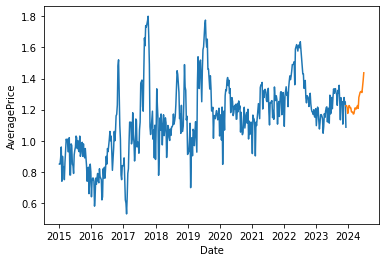

In [46]:
# Plotting historical data with forecasted data
sns.lineplot(original['Date'], original['AveragePrice'])
sns.lineplot(df_forecast['Date'], df_forecast['Average Price (USD)'])

In [47]:
# Filtering out the older dates to make the graph easier to read
original = la[['Date', 'AveragePrice']].copy()
original.loc[:, 'Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-01-04']

/Users/anthonycheung/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/anthonycheung/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


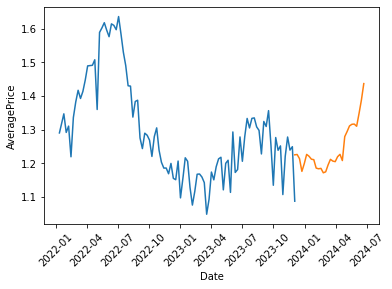

In [48]:
# Graph for avocado prices in LA from 2022 to 2024
sns.lineplot(original['Date'], original['AveragePrice'])
sns.lineplot(df_forecast['Date'], df_forecast['Average Price (USD)'])
plt.xticks(rotation=45)
plt.show()